In [77]:
'''Importieren nötiger Plugins'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import re
import torch
import io
import os
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [78]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [79]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

In [80]:
ratings = pd.read_csv('ratings100k.csv')
movies = pd.read_csv('movies100k.csv')
tmdb = pd.read_csv('tmdb.csv')

In [81]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [82]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [83]:
"""
Um etwas Zugriff zu bekommen, werden User und Filme rausgeschmissen, die zu wenig Bewertungen bekommen.
Inhaltlich passt dies auch, da diese Nutzer zuerst auf anderem Wege (Cold Start) Vorschläge erhalten
"""
f = ['count','mean']

df_movie_summary = ratings.groupby('movieId')['rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = ratings.groupby('userId')['rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 7.0
Customer minimum times of review: 140.0


In [84]:
print('Original Shape: {}'.format(ratings.shape))
ratings = ratings[~ratings['movieId'].isin(drop_movie_list)]
ratings = ratings[~ratings['userId'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(ratings.shape))

Original Shape: (100836, 4)
After Trim Shape: (63950, 4)


In [85]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [86]:
tabular_preview(ratings, movies)

movieId,260,296,318,356,480,593,1196,1198,1210,1270,1580,2028,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,5.0,2.0,3.0,3.5,3.5,3.5,5.0,5.0,5.0,3.0,4.0,4.0,4.5,5.0,2.5
177,2.5,5.0,5.0,5.0,3.5,5.0,3.0,3.5,3.0,5.0,3.5,NaN,3.0,4.0,4.0
182,3.5,5.0,4.5,5.0,3.5,4.5,3.0,3.5,2.5,3.0,2.5,3.0,5.0,5.0,5.0
249,5.0,4.0,4.5,4.5,4.0,4.0,5.0,5.0,4.5,4.5,4.5,4.5,5.0,4.5,5.0
274,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0,3.5,3.0,4.0,4.0,5.0,5.0
288,5.0,5.0,5.0,5.0,2.0,5.0,4.5,5.0,4.5,5.0,4.0,3.5,3.0,NaN,3.5
298,4.0,4.5,3.5,3.0,4.0,NaN,4.0,4.5,4.5,3.5,3.0,NaN,4.0,4.0,5.0
380,5.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,NaN,4.0
414,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0


In [87]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [88]:
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 185 users, 2949 movies
Dataset shape: (63950, 2)
Target shape: (63950,)


In [89]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [90]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [91]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[  43,   95],
        [ 119, 2130],
        [  44,  164],
        [  83,  510]])
tensor([[5.],
        [5.],
        [3.],
        [2.]])


In [92]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [93]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [94]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [95]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [97]:
valid = pd.concat([X_valid, y_valid], axis = 1)
valid14k = valid[:14000]
valid14k

,user_id,movie_id,rating
20447,43,95,5.0
58020,119,2130,5.0
20819,44,164,3.0
39319,83,510,2.0
73894,140,2663,3.0
...,...,...,...
40797,84,172,4.0
42800,89,345,2.0
36426,77,40,4.0
99097,183,1240,4.0


In [98]:
minmax = ratings.rating.min(), ratings.rating.max()
minmax

(0.5, 5.0)

In [99]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])


In [100]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/100] train: 0.9757 - val: 0.7710
loss improvement on epoch: 2
[002/100] train: 0.7862 - val: 0.6933
loss improvement on epoch: 3
[003/100] train: 0.6941 - val: 0.6314
loss improvement on epoch: 4
[004/100] train: 0.6231 - val: 0.6206
loss improvement on epoch: 5
[005/100] train: 0.6175 - val: 0.6064
loss improvement on epoch: 6
[006/100] train: 0.5869 - val: 0.6034
loss improvement on epoch: 7
[007/100] train: 0.5929 - val: 0.5999
loss improvement on epoch: 8
[008/100] train: 0.5679 - val: 0.5991
loss improvement on epoch: 9
[009/100] train: 0.5747 - val: 0.5964
loss improvement on epoch: 10
[010/100] train: 0.5507 - val: 0.5936
[011/100] train: 0.5592 - val: 0.6005
[012/100] train: 0.5324 - val: 0.5990
[013/100] train: 0.5357 - val: 0.6055
[014/100] train: 0.5096 - val: 0.6114
[015/100] train: 0.5078 - val: 0.6219
[016/100] train: 0.4709 - val: 0.6289
[017/100] train: 0.4658 - val: 0.6393
[018/100] train: 0.4186 - val: 0.6567
[019/100] train: 0.4166 -

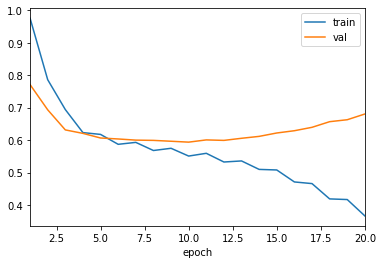

In [101]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

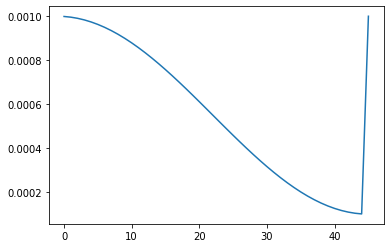

In [102]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [103]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [104]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()



In [105]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8242


In [106]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

In [107]:
truthSeries = pd.Series(groud_truth)
predSeries = pd.Series(predictions)

In [108]:
valid14k = valid14k.reset_index(drop=True)

In [109]:
valid14k

,user_id,movie_id,rating
0,43,95,5.0
1,119,2130,5.0
2,44,164,3.0
3,83,510,2.0
4,140,2663,3.0
...,...,...,...
13995,84,172,4.0
13996,89,345,2.0
13997,77,40,4.0
13998,183,1240,4.0


In [110]:
vorhersagen = pd.concat([truthSeries, predSeries, valid14k], axis=1)
vorhersagen = vorhersagen[['user_id', 'movie_id','rating', 1]]
vorhersagen = vorhersagen.rename(columns={'user_id':'uid', 'movie_id':'iid', 'rating':'r_ui', 1:'est'})
vorhersagen['diff'] = np.abs(vorhersagen['r_ui'] - vorhersagen['est'])
vorhersagen['Erlös'] = np.where(vorhersagen['est'] > 3.4 , 5, 0)

In [111]:
vorhersagen

,uid,iid,r_ui,est,diff,Erlös
0,43,95,5.0,3.611926,1.388074,5
1,119,2130,5.0,3.840100,1.159900,5
2,44,164,3.0,2.948090,0.051910,0
3,83,510,2.0,3.204175,1.204175,0
4,140,2663,3.0,2.375726,0.624274,0
...,...,...,...,...,...,...
13995,84,172,4.0,3.957201,0.042799,5
13996,89,345,2.0,2.526102,0.526102,0
13997,77,40,4.0,3.833589,0.166411,5
13998,183,1240,4.0,2.750268,1.249732,0


In [112]:
vorhersagen.to_csv('NeuralNetworkPredictions.csv', index=False)

In [113]:
vorhersagen['diff'].mean()

0.6337692981532642

In [114]:
from sklearn.decomposition import PCA

In [115]:
with open('best.weights', 'rb') as file:
    best_weights = pickle.load(file)
net.load_state_dict(best_weights)

<All keys matched successfully>

In [116]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

In [117]:
_, _, (user_id_map, movie_id_map) = create_dataset(ratings)
embed_to_original = {v: k for k, v in movie_id_map.items()}
popular_movies = ratings.groupby('movieId').movieId.count().sort_values(ascending=False).values[:1000]

In [121]:
embed = to_numpy(net.m.weight.data)
pca = PCA(n_components=5)
components = pca.fit(embed[popular_movies].T).components_
components.shape

(5, 1000)

In [122]:
components_df = pd.DataFrame(components.T, columns=[f'fc{i}' for i in range(pca.n_components_)])
movie_ids = [embed_to_original[idx] for idx in components_df.index]
meta = movies.set_index('movieId')
components_df['movie_id'] = movie_ids
components_df['title'] = meta.loc[movie_ids].title.values
components_df['genres'] = meta.loc[movie_ids].genres.values

In [123]:
components_df.sample(4)

,fc0,fc1,fc2,fc3,fc4,movie_id,title,genres
842,0.100827,-0.075393,-0.018365,0.010024,-0.014911,5608,"Das Experiment (Experiment, The) (2001)",Drama|Thriller
492,0.006168,0.002991,-0.025615,-0.033324,0.012759,410,Addams Family Values (1993),Children|Comedy|Fantasy
87,0.012174,0.055773,-0.006411,-0.009306,0.005609,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
611,0.016605,0.039979,0.012431,-0.039661,-0.046927,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy


In [134]:
components_df.sort_values(by = 'fc3',ascending=True)

,fc0,fc1,fc2,fc3,fc4,movie_id,title,genres
916,-0.031413,-0.004626,-0.021044,-0.074208,-0.054362,57528,Rambo (Rambo 4) (2008),Action|Drama|Thriller|War
932,-0.031413,-0.004626,-0.021044,-0.074208,-0.054362,64957,"Curious Case of Benjamin Button, The (2008)",Drama|Fantasy|Mystery|Romance
931,-0.031413,-0.004626,-0.021044,-0.074208,-0.054362,64839,"Wrestler, The (2008)",Drama
930,-0.031413,-0.004626,-0.021044,-0.074208,-0.054362,64614,Gran Torino (2008),Crime|Drama
908,-0.031413,-0.004626,-0.021044,-0.074208,-0.054362,53996,Transformers (2007),Action|Sci-Fi|Thriller|IMAX
...,...,...,...,...,...,...,...,...
770,-0.001109,0.034551,-0.047467,0.074858,-0.053819,858,"Godfather, The (1972)",Crime|Drama
771,-0.001109,0.034551,-0.047467,0.074858,-0.053819,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
772,-0.001109,0.034551,-0.047467,0.074858,-0.053819,1020,Cool Runnings (1993),Comedy
764,-0.001109,0.034551,-0.047467,0.074858,-0.053819,586,Home Alone (1990),Children|Comedy


In [124]:
def plot_components(components, component, ascending=False):
    fig, ax = plt.subplots(figsize=(18, 12))
    
    subset = components.sort_values(by=component, ascending=ascending).iloc[:12]
    columns = components_df.columns
    features = columns[columns.str.startswith('fc')].tolist()
    
    fc = subset[features]
    titles = ['\n'.join(wrap(t, width=10)) for t in subset.title]
    genres = subset.genres.str.replace('|', '\n')
    labels = [f'{t}\n\n{g}' for t, g in zip(titles, genres)]
    
    fc.plot(ax=ax, kind='bar')
    y_ticks = [f'{t:2.2f}' for t in ax.get_yticks()]
    ax.set_xticklabels(labels, rotation=0, fontsize=14)
    ax.set_yticklabels(y_ticks, fontsize=14)
    ax.legend(loc='best', fontsize=14)
    
    plot_title = f"Movies with {['highest', 'lowest'][ascending]} '{component}' component values" 
    ax.set_title(plot_title, fontsize=20)

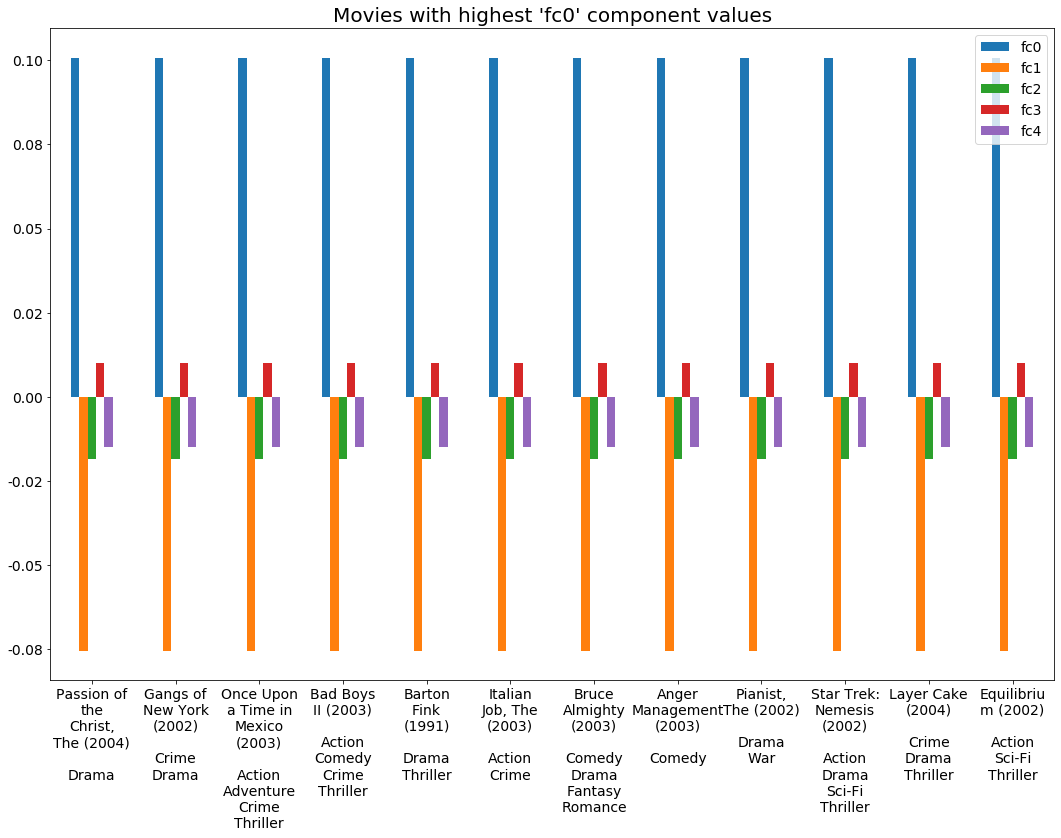

In [125]:
plot_components(components_df, 'fc0', ascending=False)

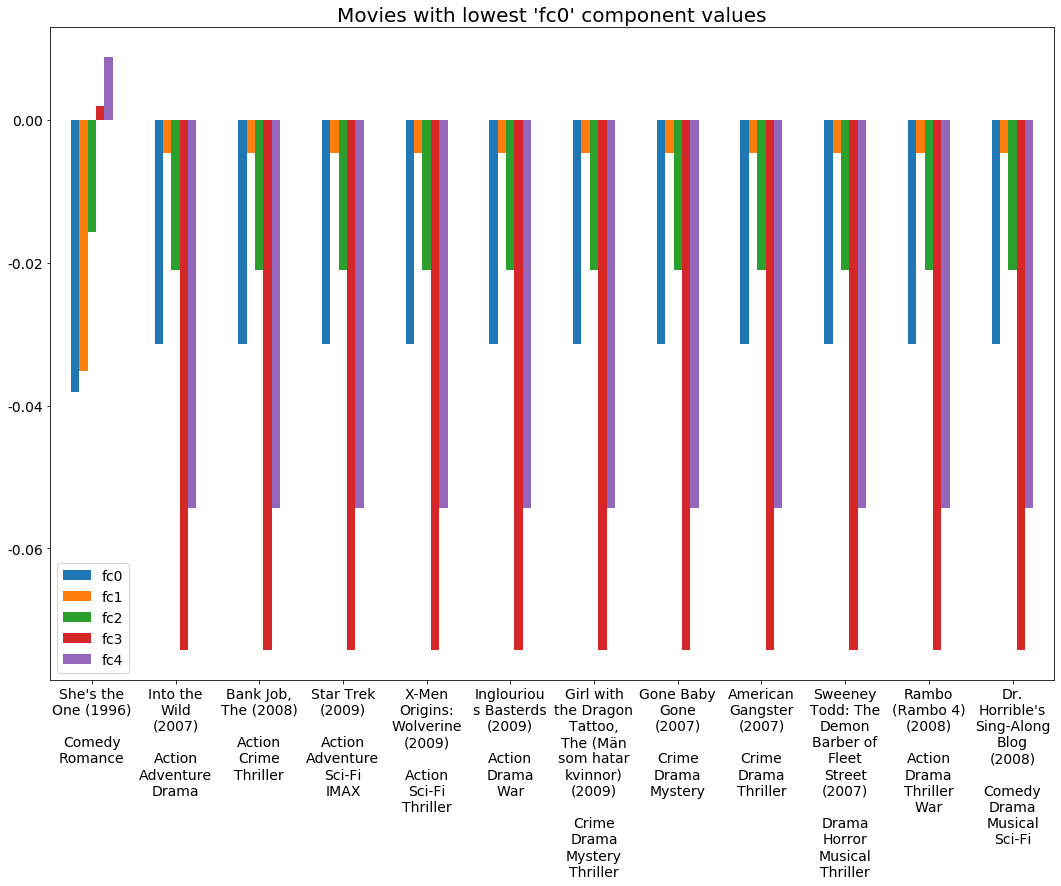

In [126]:
plot_components(components_df, 'fc0', ascending=True)